In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('max_columns',666)
pd.set_option('max_rows',666)
from scipy.stats import skew
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, Lasso
from sklearn.model_selection import GridSearchCV
import matplotlib
%matplotlib inline

In [122]:
df_train = pd.read_csv('housing_train.csv')
df_test = pd.read_csv('housing_test.csv')

<h3>Feature Concatenation</h3>
First, let's concatenate the train and test features so that all of the data manipulation will be done simulataneously. For example, we want all the values in categorical columns to be separate dummy columns. If we just look at the training set, it is possible that it won't account for all possible values.

In [123]:
total_data = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'],
                      df_test.loc[:,'MSSubClass':'SaleCondition']))

In [124]:
total_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [125]:
df_train.shape ##this indicates that there are 1460 records and 81 columns for each home in the training set

(1460, 81)

Let's take a look at the distribution of SalePrice

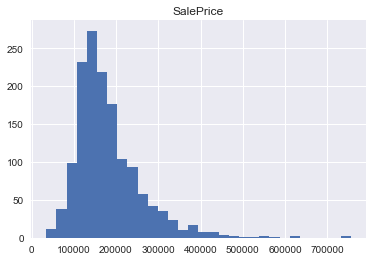

In [126]:
fig = plt.figure()
plt.hist(df_train['SalePrice'],bins = 30)
plt.title('SalePrice')

<h3>Log(X+1) transformation:</h3>
We need to do something about the right skewness of this distribution so that a regularized linear model will fit the data better. Here, an easy fix is to transform the SalePrice column using log([SalePrice]+1) as the new target variable.

In [127]:
df_train['new_sale'] = np.log1p(df_train["SalePrice"])

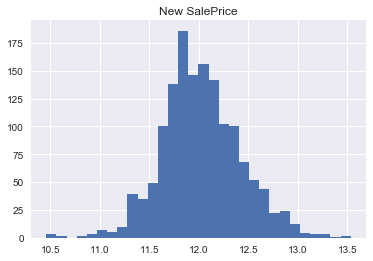

In [128]:
plt.hist(df_train['new_sale'],bins = 30)
plt.title('New SalePrice')

<h3>Checking numeric features skewness</h3>
Let's do the same thing with numeric features that have a skewed distribution.

In [129]:
#log transform skewed numeric features:
numeric_features = total_data.dtypes[total_data.dtypes != "object"].index

skewed_features = total_data[numeric_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_features = skewed_features[skewed_features > 0.70]
skewed_features = skewed_features.index

total_data[skewed_features] = np.log1p(total_data[skewed_features])

<h3> Setting Categorical Columns to Dummies </h3>

In [130]:
total_data = pd.get_dummies(total_data,drop_first=True)

<h3>Dealing with null values:</h3>
Next, I fill any null values with the mean of the columns. 

In [131]:
#filling NA's with the mean of the column:
total_data = total_data.fillna(total_data.mean())

In [132]:
##creating matrices for the training features, the testing set, and the labels for the training set.
X_train = total_data[:df_train.shape[0]]
X_test = total_data[df_train.shape[0]:]
y = df_train['new_sale']

<h3> Machine Learning: Regularization techniques </h3>
Next, I try two regularized linear regression techniques, Lasso and Ridge. I use a gridsearch to search for the best possible parameters. In order to do regularization, it is important to first scale the features.

In [133]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold, cross_val_score

<h3> Standardizing Features</h3>
First, we have to standardize each column. In order to run regularization techniques, it is necessary that each column have the same mean and standard deviation

In [134]:
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns = total_data.columns)

Let's examine the error rate for different alphas for the Ridge Regression. Alpha is the most important parameter for regularization. It determines how flexible the model is. The higher the regularization parameter, the less likely we are to overfit to the training data. If we make the parameter too large, then it actually simplifies the model too much and we won't capture all of the signal from the data.

In [135]:
ridge = Ridge()

In [136]:
ridge_r2 = []
alphas = np.logspace(-2,2.8,30)
for a in alphas:
    ridge_r2.append(cross_val_score(estimator=Ridge(alpha=a),scoring='r2',X=X_train,y=y).mean())


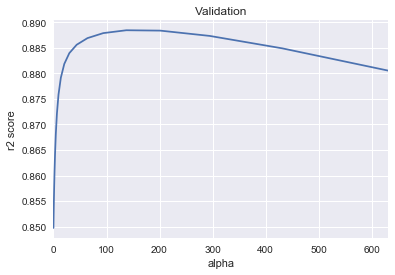

In [137]:
ridge_r2 = pd.Series(ridge_r2, index = alphas)
ridge_r2.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("r2 score")

In [138]:
ridge_error.max()

0.88844586342440424

In [139]:
ridge_error[ridge_error==Out[80]]

137.38238    0.888446
dtype: float64

We see that when we maximze the r2 value when alpha 137.38. 

In [156]:
lasso = LassoCV(alphas = np.logspace(-5,-2,30)).fit(X_train, y)

In [157]:
lasso_r2 = []
alphas = np.logspace(-5,-2,30)
for a in alphas:
    lasso_r2.append(cross_val_score(estimator=Lasso(alpha=a),scoring='r2',X=X_train,y=y).mean())

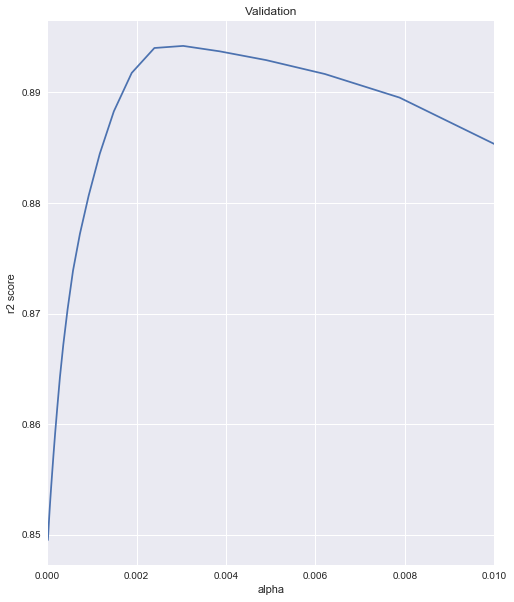

In [158]:
lasso_r2 = pd.Series(lasso_r2, index = alphas)
lasso_r2.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("r2 score")

In [143]:
lasso_r2[lasso_r2==lasso_r2.max()]

0.003039    0.894209
dtype: float64

Lasso seems to perform better! Let's build a model on lasso.

In [144]:

coef = pd.Series(lasso.coef_, index = X_train.columns)

In [145]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 183 variables and eliminated the other 62 variables


Let's take a look at the most important coefficients

In [146]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

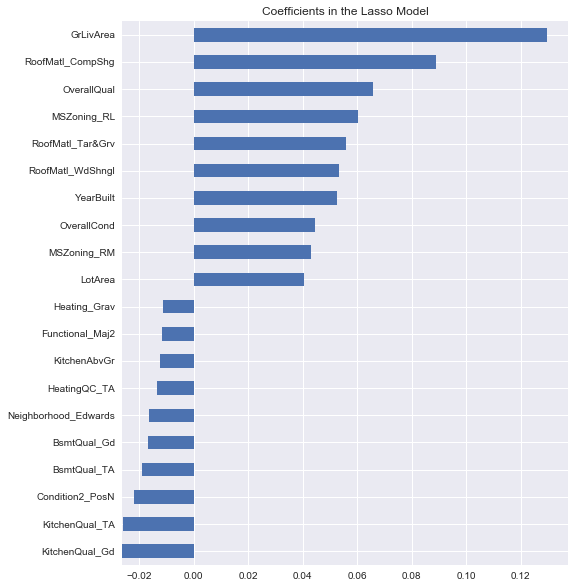

In [147]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [174]:
X_test = StandardScaler().fit_transform(X_test)

In [177]:
preds = lasso.predict(X_test)

In [151]:
solution = pd.DataFrame({"id":df_test.Id, "SalePrice":preds})
solution.to_csv("lasso_sol.csv", index = False)

In [178]:
preds[0:5]

array([ 11.66645304,  11.96228014,  12.13325718,  12.20710042,  12.24637978])